In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image

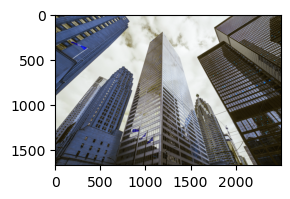

In [2]:
image1 = cv2.imread('finance.jpeg')
plt.subplot(2,2,2), plt.imshow(image1)
plt.show()

In [3]:
# crop image to square
def crop_to_square(img):
    height, width, channels = img.shape
    if height == width:
        return img
    elif height > width:
        difference = height - width
        img = img[difference//2:height - (difference - difference//2), 0:width]
    elif width > height:
        difference = width - height
        img = img[0:height, difference//2:width - (difference - difference//2)]
    return img
    
# resize image
def resize(img, size):
    img = cv2.resize(img, size)
    return img

In [4]:
im = crop_to_square(image1)
img = resize(im, (512,512))

In [5]:
# Convert to grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Convert to binary
ret, thresh1 = cv2.threshold(gray1, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours1, hierarchy1 = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours
contoured_image = cv2.drawContours(img, contours1, -1, (0, 255, 0), 3)

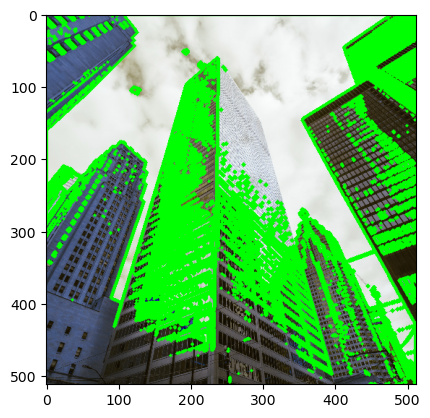

In [6]:
# Display image 1
plt.subplot(1,1,1), plt.imshow(contoured_image)
plt.show()

# Fourier Transormation => NumPy FFT

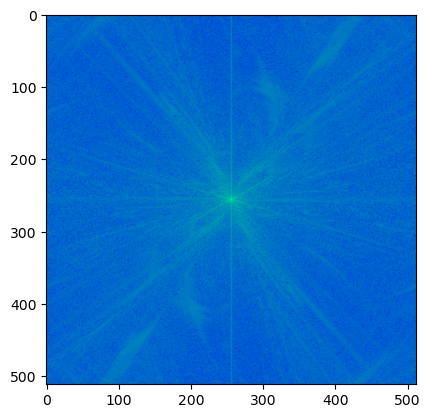

In [7]:
fft = np.fft.fft2(gray1)
fft_shift = np.fft.fftshift(fft)
magnitude_spectrum = 20*np.log(np.abs(fft_shift))

plt.subplot(1,1,1), plt.imshow(magnitude_spectrum, cmap = 'winter')
plt.show()

### Blurring using low-pass filter

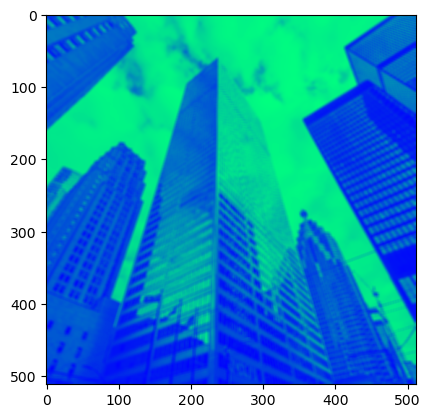

In [8]:
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(gray1,-1,kernel)
plt.subplot(1,1,1), plt.imshow(dst, cmap = 'winter')
plt.show()

### Sharpening using high pass filter

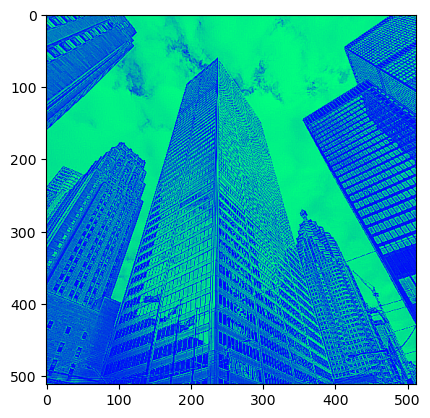

In [9]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpened = cv2.filter2D(gray1, -1, kernel)
plt.subplot(1,1,1), plt.imshow(sharpened, cmap = 'winter')
plt.show()

### Edge Detection

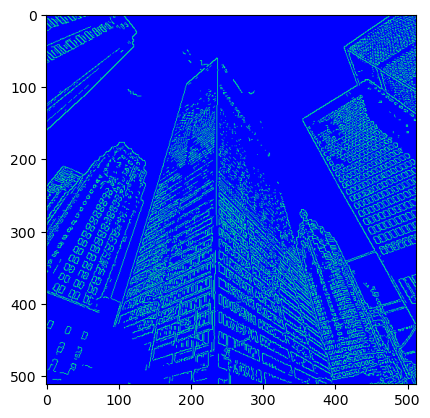

In [10]:
# Edge Detection
edges = cv2.Canny(gray1,255, 200)
plt.subplot(1,1,1), plt.imshow(edges, cmap = 'winter')
plt.show()

# Fourier Transformation => scipy

In [11]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from scipy import signal
from numpy.fft import fft2, fftshift, ifft2

In [12]:
casa = Image.open("casaloma.jpeg")
casa = casa.crop((0, 0, 512, 512))

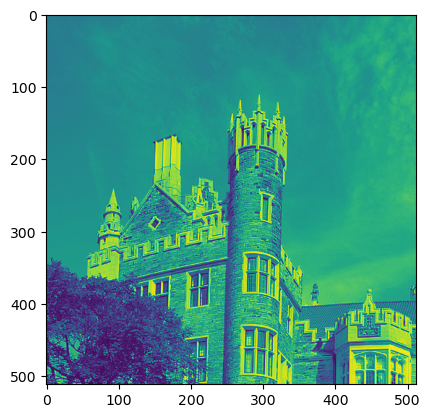

In [13]:
x=casa.convert("L")
y=np.asarray(x.getdata(),dtype=np.float64).reshape((x.size[1],x.size[0]))
y=np.matrix(y)
y=np.asarray(y,dtype=np.uint8)

plt.subplot(1,1,1), plt.imshow(y, cmap = 'viridis')
plt.show()

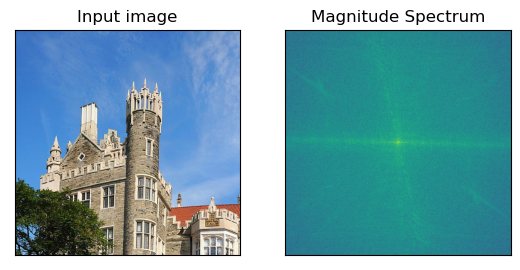

In [14]:
# apply fft2 that refers to 2D fft. fft2() provides us the frequency transform which will be a complex array. It first argument is a greyscale image.
F = fft2(y)
# next, we apply ffshift() that essentially performs multiplication operation f(x,y)(-1)^(x+y) and then takes the FT of this product.
# we want to place the zero frequency component in the center. Otherwise, it will be at the top left corner. We shift the result in both directions.
F1 = fftshift(F)
# we take the magnitude of the complex array and then take the log of it. This is done to enhance the contrast of the image.
# we then normalize the image to the range [0,1] so that we can display it using imshow().
magnitude_spectrum = 20*np.log(np.abs(F1))
magnitude_spectrum = magnitude_spectrum/np.max(magnitude_spectrum)

plt.subplot(121), plt.imshow(casa, cmap = 'viridis')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'viridis')
plt.title('Magnitude Spectrum'), plt.xticks([]),plt.yticks([])
plt.show()


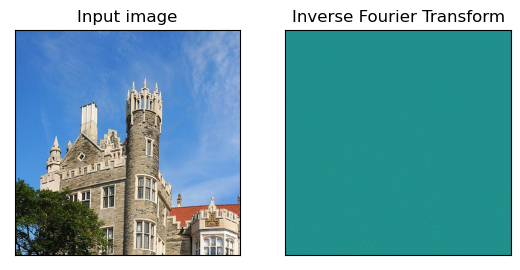

In [15]:
# undo shift operation
F2 = ifft2(F1)
# take the real part of the inverse transform
F3 = np.real(F2)
# normalize the image to the range [0,1] so that we can display it using imshow().
F3 = F3/np.max(F3)

plt.subplot(121), plt.imshow(casa, cmap = 'viridis')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(F3, cmap = 'viridis')
plt.title('Inverse Fourier Transform'), plt.xticks([]),plt.yticks([])
plt.show()

## Gaussian Window and Laplacian Gaussian
#### Mathematical functions are supplemented from Wikipedia and turned into code

In [16]:
# The Gaussian window is defined here
def gaussian_window(shape, sigma=1):
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    return h

# The Gaussian filter is defined here
def gaussian_filter(shape, sigma=1):
    h = gaussian_window(shape, sigma)
    hsum = np.sum(h)
    if hsum != 0:
        h /= hsum
    return h

# The Gaussian filter is applied here
def apply_gaussian_filter(image, sigma=1):
    h = gaussian_filter(image.shape, sigma)
    filtered_image = signal.convolve2d(image, h, mode='same', boundary='symm')
    return filtered_image

In [17]:
filtered_image = apply_gaussian_filter(y, sigma=1)

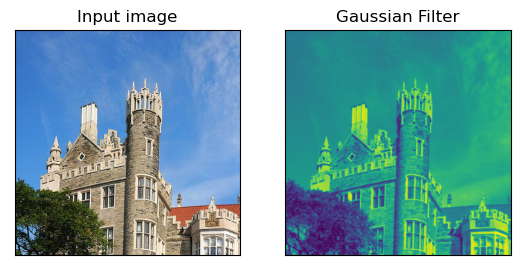

In [18]:
plt.subplot(121), plt.imshow(casa, cmap = 'viridis')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(filtered_image, cmap = 'viridis')
plt.title('Gaussian Filter'), plt.xticks([]),plt.yticks([])
plt.show()

In [19]:
# The Laplacian of Gaussian filter is defined here
def laplacian_of_gaussian_filter(shape, sigma=1):
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    h = -h * (x*x + y*y - 2*sigma*sigma) / (sigma*sigma*sigma*sigma)
    hsum = np.sum(h)
    if hsum != 0:
        h /= hsum
    return h

# The Laplacian of Gaussian filter is applied here
def apply_laplacian_of_gaussian_filter(image, sigma=1):
    h = laplacian_of_gaussian_filter(image.shape, sigma)
    filtered_image = signal.convolve2d(image, h, mode='same', boundary='symm')
    return filtered_image

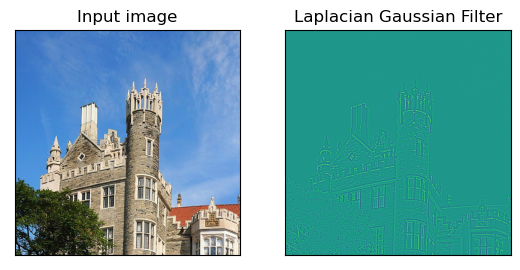

In [25]:
filtered_image = apply_laplacian_of_gaussian_filter(y, sigma=1)

plt.subplot(121), plt.imshow(casa, cmap = 'viridis')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(filtered_image, cmap = 'viridis')
plt.title('Laplacian Gaussian Filter'), plt.xticks([]),plt.yticks([])
plt.show()

## Sharpening using high pass filter

#### Seperating the low frequency of the image from Gaussian, helped us acquire the high pass efficiently

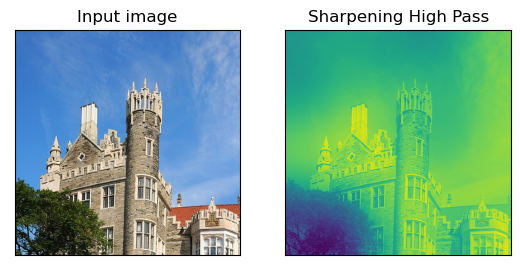

In [27]:
# Sharpening high pass
def sharpening_high_pass(image, sigma=1):
    h = laplacian_of_gaussian_filter(image.shape, sigma)
    filtered_image = signal.convolve2d(image, h, mode='same', boundary='symm')
    filtered_image = image + filtered_image
    return filtered_image

filtered_image = sharpening_high_pass(y, sigma=100)

plt.subplot(121), plt.imshow(casa, cmap = 'viridis')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(filtered_image, cmap = 'viridis')
plt.title('Sharpening High Pass'), plt.xticks([]),plt.yticks([])
plt.show()

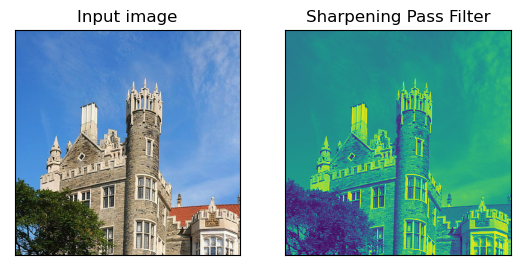

In [26]:
def high_pass_filter(image, sigma=1):
    h = gaussian_filter(image.shape, sigma)
    filtered_image = image - h
    return filtered_image

filtered_image = high_pass_filter(y, sigma=100)

plt.subplot(121), plt.imshow(casa, cmap = 'viridis')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(filtered_image, cmap = 'viridis')
plt.title('Sharpening Pass Filter'), plt.xticks([]),plt.yticks([])
plt.show()